In [1]:
%matplotlib inline
import pandas as pd
from tqdm.notebook import tqdm
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
import os
import re
import string
import random

In [2]:
train = pd.read_csv('/content/captionTrain.csv')
train.head()

,sentence
0,사람이 다가오고 있습니다
1,사람과 자전거가 다가오고 있습니다
2,자전거와 사람이 다가오고 있습니다
3,사람과 자전거가 있습니다
4,자전거와 사람이 있습니다


In [3]:
# 문장 길이 확인
sentence_num = 0

for i, row in train.iterrows():
  sentence = row['sentence']
  sentence_num += len(sentence.split())

print('문장 당 평균 길이: {}'.format(sentence_num / len(train)))

문장 당 평균 길이: 4.47


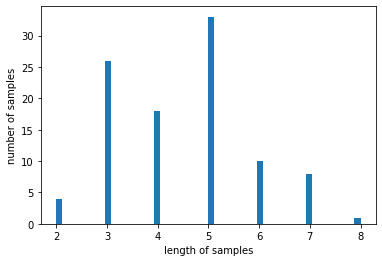

In [4]:
plt.hist([len(row['sentence'].split()) for i, row in train.iterrows()], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [10]:
# sentence2vec

sentence_list = []
for i, row in train.iterrows():
  sentence = row['sentence']
  sentence_list.append(sentence)

text_ds = tf.data.Dataset.from_tensor_slices(sentence_list)

batch_size = 30
text_ds = text_ds.shuffle(buffer_size=256)
text_ds = text_ds.batch(batch_size)

vocab_size = 100
maxlen = 8

vectorize_layer = TextVectorization(
    max_tokens=vocab_size - 1,
    output_mode = 'int',
    output_sequence_length = maxlen + 1,
)
vectorize_layer.adapt(text_ds)
vocab = vectorize_layer.get_vocabulary()

In [13]:
vocab

['',
 '[UNK]',
 '있습니다',
 '사람이',
 '탄',
 '여러',
 '사람과',
 '놓여',
 '전동킥보드가',
 '자전거가',
 '전동킥보드를',
 '자전거를',
 '볼라드가',
 '자전거',
 '오토바이가',
 '오토바이를',
 '오토바이',
 '여럿',
 '대가',
 '있고',
 '다가오고',
 '사람',
 '자동차가',
 '대와',
 '대',
 '전동킥보드와',
 '자전거와',
 '오토바이와',
 '전동킥보드',
 '다가옵니다',
 '차가',
 '차',
 '자동차와',
 '세워져',
 '명과',
 '두',
 '다수',
 '걸어갑니다',
 '차와',
 '여러개가',
 '볼라드와',
 '볼라드',
 '명이',
 '둘',
 '걸어가고',
 '폴라드',
 '타고',
 '킥보드가',
 '전동',
 '여럿과',
 '앞으로',
 '설치되어',
 '설치',
 '서',
 '사람들이',
 '명의',
 '되어',
 '늘어서']

In [14]:
def prepare_lm_inputs_labels(text):
    """
    Shift word sequences by 1 position so that the target for position (i) is
    word at position (i+1). The model will use all words up till position (i)
    to predict the next word.
    """
    text = tf.expand_dims(text, -1)
    tokenized_sentences = vectorize_layer(text)
    x = tokenized_sentences[:, :-1]
    y = tokenized_sentences[:, 1:]
    return x, y
    
text_ds = text_ds.map(prepare_lm_inputs_labels)
text_ds = text_ds.prefetch(tf.data.experimental.AUTOTUNE)

In [15]:
class TokenAndPositionEmbedding(layers.Layer):
    def __init__(self, maxlen, vocab_size, embed_dim):
        super(TokenAndPositionEmbedding, self).__init__()
        self.token_emb = layers.Embedding(input_dim=vocab_size, output_dim=embed_dim)
        self.pos_emb = layers.Embedding(input_dim=maxlen, output_dim=embed_dim)

    def call(self, x):
        maxlen = tf.shape(x)[-1]
        # token 위치에 따른 embedding을 하기위함
        positions = tf.range(start=0, limit=maxlen, delta=1)
        positions = self.pos_emb(positions)
        x = self.token_emb(x)
        return x + positions

In [16]:
def causal_attention_mask(batch_size, n_dest, n_src, dtype):
    """
    Mask the upper half of the dot product matrix in self attention.
    This prevents flow of information from future tokens to current token.
    1's in the lower triangle, counting from the lower right corner.
    """
    i = tf.range(n_dest)[:, None]
    j = tf.range(n_src)
    m = i >= j - n_src + n_dest
    mask = tf.cast(m, dtype)
    mask = tf.reshape(mask, [1, n_dest, n_src])
    mult = tf.concat(
        [tf.expand_dims(batch_size, -1), tf.constant([1, 1], dtype=tf.int32)], 0
    )
    return tf.tile(mask, mult)


class TransformerBlock(layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super(TransformerBlock, self).__init__()
        self.att = layers.MultiHeadAttention(num_heads, embed_dim)
        self.ffn = keras.Sequential(
            [layers.Dense(ff_dim, activation="relu"), layers.Dense(embed_dim),]
        )
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = layers.Dropout(rate)
        self.dropout2 = layers.Dropout(rate)

    def call(self, inputs):
        input_shape = tf.shape(inputs)
        batch_size = input_shape[0]
        seq_len = input_shape[1]
        causal_mask = causal_attention_mask(batch_size, seq_len, seq_len, tf.bool)
        attention_output = self.att(inputs, inputs, attention_mask=causal_mask)
        attention_output = self.dropout1(attention_output)
        out1 = self.layernorm1(inputs + attention_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output)
        return self.layernorm2(out1 + ffn_output)

In [17]:
# 변수 정의 및 모델 함수 정의

embed_dim = 256  # Embedding size for each token
num_heads = 2  # Number of attention heads
feed_forward_dim = 256  # Hidden layer size in feed forward network inside transformer

def create_model():
    inputs = layers.Input(shape=(maxlen,), dtype=tf.int32) 
    # input 정의
    
    embedding_layer = TokenAndPositionEmbedding(maxlen, vocab_size, embed_dim) 
    # token Embedding + positional Embedding layer class 정의
    
    x = embedding_layer(inputs) 
    # 선언한 Embedding layer class 이용해 Embedding
    
    transformer_block = TransformerBlock(embed_dim, num_heads, feed_forward_dim) 
    # transformer block layer class 정의
    
    x = transformer_block(x) 
    # 선언한 transformer layer class 이용해 학습
    
    outputs = layers.Dense(vocab_size)(x) 
    # 압축된 결과를 vocab에 맞춰 팽창 (후보단어 선별을 위한 각 단어에 대한 결과치 도출)
    
    model = keras.Model(inputs=inputs, outputs=[outputs, x])  
    # model 정의
    
    loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True) 
    model.compile(
        "adam", loss=[loss_fn, None],
    )  # No loss and optimization based on word embeddings from transformer block
    model.summary()
    return model

In [24]:
class TextGenerator(keras.callbacks.Callback):
    """A callback to generate text from a trained model.
    1. Feed some starting prompt to the model
    2. Predict probabilities for the next token
    3. Sample the next token and add it to the next input

    Arguments:
        max_tokens: Integer, the number of tokens to be generated after prompt.
        start_tokens: List of integers, the token indices for the starting prompt.
        index_to_word: List of strings, obtained from the TextVectorization layer.
        top_k: Integer, sample from the `top_k` token predictions.
        print_every: Integer, print after this many epochs.
    """

    def __init__(
        self, max_tokens, start_tokens, index_to_word, top_k=10, print_every=1
    ):
        self.max_tokens = max_tokens
        self.start_tokens = start_tokens
        self.index_to_word = index_to_word
        self.print_every = print_every
        self.k = top_k

    def sample_from(self, logits):
        logits, indices = tf.math.top_k(logits, k=self.k, sorted=True)
        indices = np.asarray(indices).astype("int32")
        preds = keras.activations.softmax(tf.expand_dims(logits, 0))[0]
        preds = np.asarray(preds).astype("float32")
        return np.random.choice(indices, p=preds)

    def detokenize(self, number):
        return self.index_to_word[number]

    def on_epoch_end(self, epoch, logs=None):
        start_tokens = [_ for _ in self.start_tokens]
        if (epoch + 1) % self.print_every != 0:
            return
        num_tokens_generated = 0
        tokens_generated = []
        while num_tokens_generated <= self.max_tokens:
            pad_len = maxlen - len(start_tokens)
            sample_index = len(start_tokens) - 1
            if pad_len < 0:
                x = start_tokens[:maxlen]
                sample_index = maxlen - 1
            elif pad_len > 0:
                x = start_tokens + [0] * pad_len
            else:
                x = start_tokens
            x = np.array([x])
            y, _ = self.model.predict(x)
            sample_token = self.sample_from(y[0][sample_index])
            tokens_generated.append(sample_token)
            start_tokens.append(sample_token)
            num_tokens_generated = len(tokens_generated)
        txt = " ".join(
            [self.detokenize(_) for _ in self.start_tokens + tokens_generated]
        )
        generated_sentence.append(txt)
        print()
        print(f"generated text: {txt}\n")

In [25]:
# Tokenize starting prompt
word_to_index = {}
for index, word in enumerate(vocab):
    word_to_index[word] = index

start_prompt = "자전거"
start_tokens = [word_to_index.get(_, 1) for _ in start_prompt.split()]
num_tokens_generated = 40
text_gen_callback = TextGenerator(num_tokens_generated, start_tokens, vocab)

generated_sentence = []
model = create_model()
model.fit(text_ds, verbose=1, epochs=10, callbacks=[text_gen_callback])

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 8)]               0         
                                                                 
 token_and_position_embeddin  (None, 8, 256)           27648     
 g_3 (TokenAndPositionEmbedd                                     
 ing)                                                            
                                                                 
 transformer_block_3 (Transf  (None, 8, 256)           658688    
 ormerBlock)                                                     
                                                                 
 dense_11 (Dense)            (None, 8, 100)            25700     
                                                                 
Total params: 712,036
Trainable params: 712,036
Non-trainable params: 0
_____________________________________________________

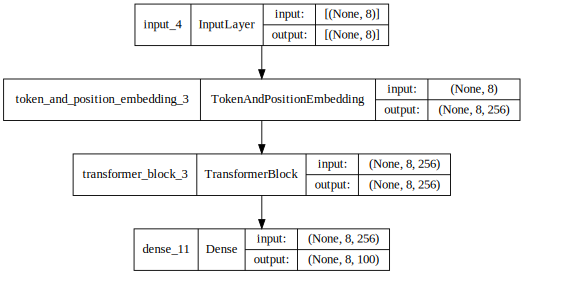

In [41]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

%matplotlib inline

SVG(model_to_dot(model, show_shapes=True, dpi=65).create(prog='dot', format='svg'))

In [32]:
generated_sentence_list = [senten.rstrip() for senten in generated_sentence]
generated_sentence_list

['자전거 탄 있습니다',
 '자전거 여러 있고 사람이 있습니다',
 '자전거 여러 대와 사람이 걸어갑니다',
 '자전거 여러 대와 다가오고 있습니다',
 '자전거 차 오토바이 여러 대가 있습니다',
 '자전거 여러 대와 사람이 있습니다',
 '자전거 사람 여러 대가 있습니다',
 '자전거 여러 대와 사람이 있습니다',
 '자전거 여러 대가 세워져 있습니다',
 '자전거 여러 대와 전동 킥보드가 있습니다']